In [1]:
import tensorflow as tf

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt

In [3]:
WRK_DIR = '/home/boo/Documents/Personal/Projects/ImageResolution/'
PATH = os.path.join(WRK_DIR, 'Data')

In [4]:
train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'val')

In [5]:
train_cats_dir = os.path.join(train_dir, 'cats')  # directory with our training cat pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')  # directory with our training dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')  # directory with our validation cat pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')  # directory with our validation dog pictures

In [6]:
num_cats_tr = len(os.listdir(train_cats_dir))
num_dogs_tr = len(os.listdir(train_dogs_dir))

num_cats_val = len(os.listdir(validation_cats_dir))
num_dogs_val = len(os.listdir(validation_dogs_dir))

total_train = num_cats_tr + num_dogs_tr
total_val = num_cats_val + num_dogs_val

In [7]:
print('total training cat images:', num_cats_tr)
print('total training dog images:', num_dogs_tr)

print('total validation cat images:', num_cats_val)
print('total validation dog images:', num_dogs_val)
print("--")
print("Total training images:", total_train)
print("Total validation images:", total_val)

total training cat images: 2304
total training dog images: 2256
total validation cat images: 432
total validation dog images: 423
--
Total training images: 4560
Total validation images: 855


In [8]:
batch_size = 128
epochs = 7
IMG_HEIGHT = 224
IMG_WIDTH = 224

In [9]:
train_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our training data
validation_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our validation data

In [10]:
train_data_gen = train_image_generator.flow_from_directory(batch_size=4558,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='binary')

Found 4558 images belonging to 2 classes.


In [11]:
val_data_gen = validation_image_generator.flow_from_directory(batch_size=855,
                                                              directory=validation_dir,
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              class_mode='binary')

Found 855 images belonging to 2 classes.


In [12]:
X_train, y_train = next(train_data_gen)
X_val, y_val = next(val_data_gen)

## VGG19: Model Preparation

In [13]:
from keras.applications.vgg19 import VGG19
model = VGG19(include_top=False)
model.summary()

Using TensorFlow backend.


Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

In [14]:
cnn_output=model.predict(X_train)

## Fully-Connected Layer Tuning 

In [21]:
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from keras.callbacks import EarlyStopping
from keras.layers import GlobalAveragePooling2D
from keras.layers import Dense, Flatten
from keras.models import Sequential


def train_model_neural_net(X_train,y_train,X_val,y_val):
    mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', verbose=0, save_best_only=True)
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=8)
    print(X_train.shape[1:])
    model = Sequential()
    #model.add(GlobalAveragePooling2D(input_shape=(2, 2, 512)))
    model.add(GlobalAveragePooling2D(input_shape=X_train.shape[1:]))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(4, activation='softmax'))
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    history=model.fit(X_train,y_train ,validation_data=(X_val,y_val),epochs=50,shuffle=True,batch_size=128,callbacks=[es, mc], verbose=0)
    saved_model = load_model('best_model.h5')
    train_pred =saved_model.predict(X_train)            
    valid_pred =saved_model.predict(X_val)
    train_loss, train_acc = saved_model.evaluate(X_train,y_train, verbose=0)
    val_loss, val_acc = saved_model.evaluate(X_val,y_val, verbose=0)
    print('accuracy Train: %.3f, Test: %.3f' % (train_acc, val_acc))
    print('loss Train: %.3f, Test: %.3f' % (train_loss, val_loss))
    #test_pred = saved_model.predict(X_test)
    return train_pred ,valid_pred,saved_model,train_loss, train_acc, val_acc,val_loss

def train_kfold_neural_net(X_train,y_train,split=5):
    final_train_pred=np.zeros((X_train.shape[0],4))
    from sklearn.model_selection import StratifiedKFold
    kf =  StratifiedKFold(n_splits=split, shuffle=False)
    i=1
    score=0
    
    accuracies=np.array([])
    losses=np.array([])
    
    val_accuracies = np.array([])
    train_accuracies = np.array([])
    
    val_losses = np.array([])
    train_losses = np.array([])
    
    for train_index, val_index in kf.split(X_train, y_train):
        
        print("fold:"+str(i))
        train_fold_features, val_fold_features = X_train[train_index], X_train[val_index]
        train_fold_target, val_fold_target = y_train[train_index], y_train[val_index] 
        
        train_pred ,valid_pred,model,train_loss, train_acc, val_acc, val_loss=train_model_neural_net(
            X_train=train_fold_features,
            y_train= train_fold_target,
            X_val= val_fold_features,
            y_val= val_fold_target)
        
        accuracies=np.append(accuracies,val_acc)
        losses=np.append(losses,val_loss)
        
        val_accuracies=np.append(val_accuracies,val_acc)
        train_accuracies=np.append(train_accuracies,train_acc)
        
        val_losses=np.append(val_losses,val_loss)
        train_losses=np.append(train_losses,train_loss)
        
        final_train_pred[val_index]=valid_pred
        i=i+1
    
    avg_acc=accuracies.sum() / 5
    avg_loss=losses.sum() / 5
    print('overall performance avg_acc: %.3f, avg_loss: %.3f' % (avg_acc, avg_loss))
    return final_train_pred,model,avg_acc,avg_loss,val_accuracies,train_accuracies,val_losses,train_losses

final_train_pred,model,avg_acc,avg_loss, val_accuracies,train_accuracies,val_losses,train_losses=\
train_kfold_neural_net(cnn_output,y_train,split=5)

fold:1
(7, 7, 512)
accuracy Train: 0.952, Test: 0.944
loss Train: 0.122, Test: 0.156
fold:2
(7, 7, 512)
accuracy Train: 0.952, Test: 0.941
loss Train: 0.126, Test: 0.141
fold:3
(7, 7, 512)
accuracy Train: 0.962, Test: 0.941
loss Train: 0.102, Test: 0.137
fold:4
(7, 7, 512)
accuracy Train: 0.953, Test: 0.933
loss Train: 0.122, Test: 0.190
fold:5
(7, 7, 512)
accuracy Train: 0.957, Test: 0.908
loss Train: 0.120, Test: 0.198
overall performance avg_acc: 0.933, avg_loss: 0.164


In [23]:
len(val_accuracies)

5

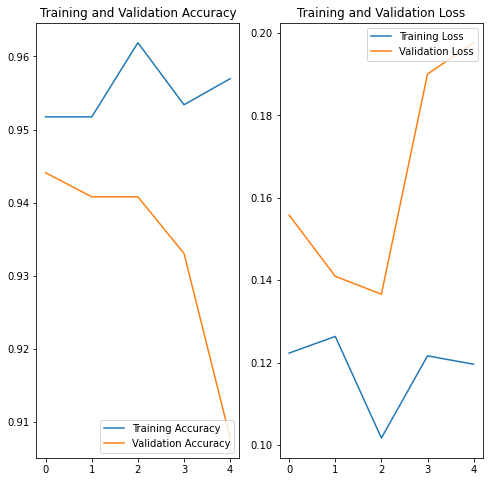

In [25]:
folds_range = range(5)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(folds_range, train_accuracies, label='Training Accuracy')
plt.plot(folds_range, val_accuracies, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(folds_range, train_losses, label='Training Loss')
plt.plot(folds_range, val_losses, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()